## Page Rank

The goal of information retrieval is to find resources that are relevant and high quality.
"Relevant" and "quality" can be hard to define, and they depend on what kind of resources you are searching.

In the context of web search, relevance usually depends on the contents of a web page: if a web page contains the search terms, we assume that it is relevant to the search terms.

Quality usually depends on the links between pages.
If there are many links to a particular page, we think it is more likely to be high quality, especially if those links come from pages that are high quality themselves.

One of the first algorithms to quantify quality in this is PageRank, which was the core of Google's original search engine.
As someone who used earlier search engines, like Alta Vista, I can tell you first-hand what a big difference it made.

PageRank is described in ["The PageRank citation ranking: Bringing order to the Web"](https://web.archive.org/web/20110818093436/http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf) by  Page, Brin, Motwani, and Winograd.

It is a surprisingly simple algorithm; it can be computed and updated efficiently; and it is highly effective at identifying good quality pages.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os

In [ ]:
pages_link = 'http://www.cs.ubc.ca/~nando/340-2009/lectures/pages.zip'
dlname = 'pages.zip'
#This will unzip into a directory called pages
if not os.path.exists('./%s' % dlname):
    !wget -O {dlname} {pages_link}
    os.system('unzip %s' % dlname)
else:
    print('%s already downloaded!' % dlname)

--2023-07-31 18:54:54--  http://www.cs.ubc.ca/~nando/340-2009/lectures/pages.zip
Resolving www.cs.ubc.ca (www.cs.ubc.ca)... 142.103.6.5
Connecting to www.cs.ubc.ca (www.cs.ubc.ca)|142.103.6.5|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.ubc.ca/~nando/340-2009/lectures/pages.zip [following]
--2023-07-31 18:54:55--  https://www.cs.ubc.ca/~nando/340-2009/lectures/pages.zip
Connecting to www.cs.ubc.ca (www.cs.ubc.ca)|142.103.6.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5329 (5.2K) [application/zip]
Saving to: ‘pages.zip’

pages.zip           100%[===================>]   5.20K  --.-KB/s    in 0s      

2023-07-31 18:54:56 (935 MB/s) - ‘pages.zip’ saved [5329/5329]



In [ ]:
links = {}
for fname in os.listdir(dlname[:-4]):
    links[fname] = []
    f = open(dlname[:-4] + '/' + fname)
    for line in f.readlines():
        while True:
            p = line.partition('<a href="http://')[2]
            if p == '':
                break
            url, _, line = p.partition('\">')
            links[fname].append(url)
    f.close()
links

{'jonvoight.html': ['angelinajolie.html',
  'angelinajolie.html',
  'bradpitt.html'],
 'jenniferaniston.html': [],
 'robertdeniro.html': ['martinscorcese.html'],
 'bradpitt.html': ['jenniferaniston.html',
  'angelinajolie.html',
  'martinscorcese.html',
  'angelinajolie.html'],
 'martinscorcese.html': [],
 'angelinajolie.html': ['jonvoight.html', 'bradpitt.html']}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
num_pages = len(links.keys())
A = np.zeros((num_pages, num_pages))

#Assign identity numbers to each page, along with a reverse lookup
idx = {}
lookup = {}
keys = sorted(links.keys())
for n,k in enumerate(keys):
    idx[k] = n
    lookup[n] = k

#Go through all keys, and add a 1 for each link to another page
for k in links.keys():
    v = links[k]
    for e in v:
        A[idx[k],idx[e]] = 1
print(keys)
A

['angelinajolie.html', 'bradpitt.html', 'jenniferaniston.html', 'jonvoight.html', 'martinscorcese.html', 'robertdeniro.html']


array([[0., 1., 0., 1., 0., 0.],
       [1., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])

In [ ]:
graph = nx.Graph(A)

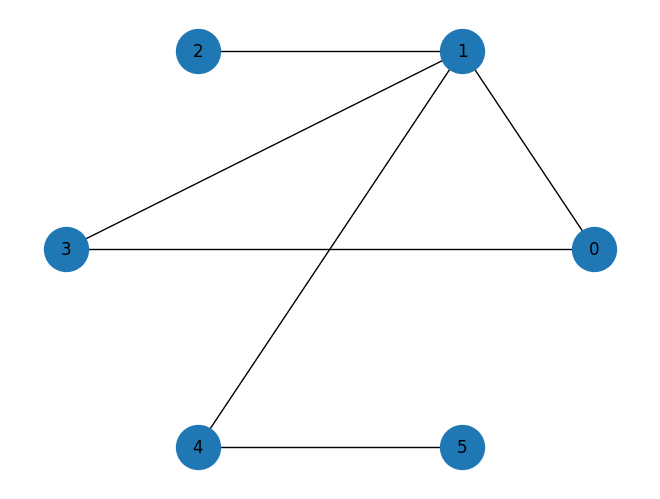

In [ ]:
# plt.figure(figsize=(8,8))
nx.draw_circular(graph, node_size=1000, with_labels=True)

Page Rank measures importance of nodes in a graph using the link structure of the web. A “vote” from an important page is worth more. Specifically, if  a page $i$ with importance $r_i$ has $d_i$ out-links, then each link gets $\frac{r_i}{d_i}$ votes. Thus, the importance of a Page $j$, represented as $r_j$ is the sum of the votes on its in links.
$$ r_j^{(t+1)} = \sum_{i \rightarrow j} \frac{r_i^{(t)}}{d_i}$$
where $d_i$ is out degree of node $i$<br>


This can be written in matrix from $r = M \cdot r$ where $M$ is the stochastic adjacency matrix.

But this can lead to two problems:<br>
1. Some pages are dead ends (have no out-links)
  - Such pages cause importance to “leak out”<br>

2. Spider traps (all out-links are within the group)
  - Eventually spider traps absorb all importance

**Solution:** At each time step, the random surfer has two options
- With prob. $\beta$, follow a link at random
- With prob. 1-$\beta$, jump to a random page<br>

Common values for $\beta$ are in the range 0.8 to 0.9<br>


Page Rank Equation:
$$ r_j = \sum_{i \rightarrow j} \beta \frac{r_i}{d_i} + (1-\beta)\frac{1}{N}$$
<br>
The Google Matrix G:
$$G = \beta M + (1-\beta)\left [ \frac{1}{N}\right ]_{N\times N}$$

In [ ]:
M = A / (A.sum(axis=1)[:, None]+1e-31)
M

array([[0.        , 0.5       , 0.        , 0.5       , 0.        ,
        0.        ],
       [0.33333333, 0.        , 0.33333333, 0.        , 0.33333333,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.5       , 0.5       , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        ]])

In [ ]:
# Google Matrix
beta = 0.85
N = M.shape[0]

p = np.full((N, N), 1/N)

GM = beta * M + (1 - beta) * p
GM

array([[0.025     , 0.45      , 0.025     , 0.45      , 0.025     ,
        0.025     ],
       [0.30833333, 0.025     , 0.30833333, 0.025     , 0.30833333,
        0.025     ],
       [0.025     , 0.025     , 0.025     , 0.025     , 0.025     ,
        0.025     ],
       [0.45      , 0.45      , 0.025     , 0.025     , 0.025     ,
        0.025     ],
       [0.025     , 0.025     , 0.025     , 0.025     , 0.025     ,
        0.025     ],
       [0.025     , 0.025     , 0.025     , 0.025     , 0.875     ,
        0.025     ]])

In [ ]:
# initialize ranks for each node
r = np.full(N, 1/N)
r

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

In [ ]:
np.ones((2,3)).sum(axis=1)

array([3., 3.])

{0: 0.1996124031007752, 1: 0.23255813953488372, 2: 0.1007751937984496, 3: 0.13372093023255813, 4: 0.2984496124031007, 5: 0.03488372093023256}


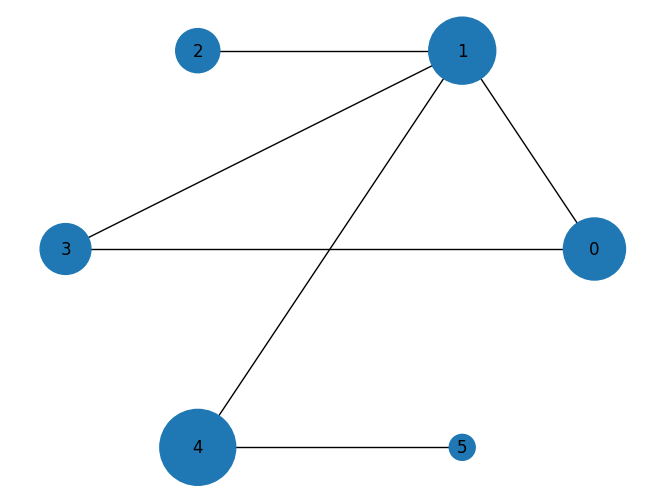

{0: 0.22359929598122616, 1: 0.2522733939571722, 2: 0.13757700205338808, 3: 0.1662511000293341, 4: 0.1824581988853036, 5: 0.03784100909357582}


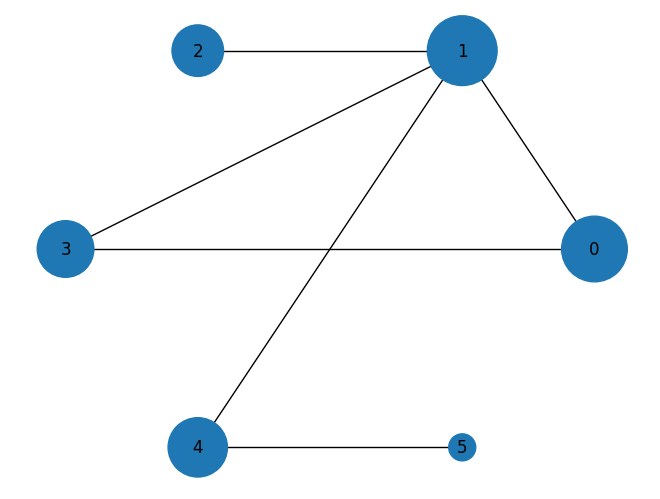

{0: 0.2295893525141203, 1: 0.2619426591179256, 2: 0.13252943270270454, 3: 0.1648827393065098, 4: 0.17671374555907024, 5: 0.03434207079966958}


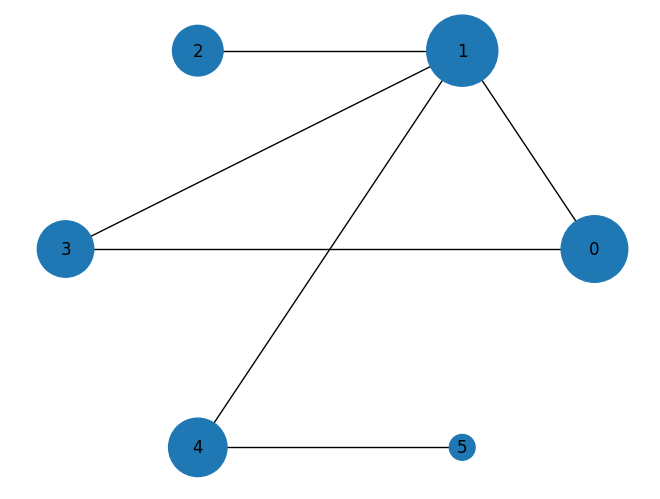

{0: 0.229659892866156, 1: 0.26134760964614573, 2: 0.13459674252618672, 3: 0.16628445930617644, 4: 0.17419658727823184, 5: 0.033914708377103114}


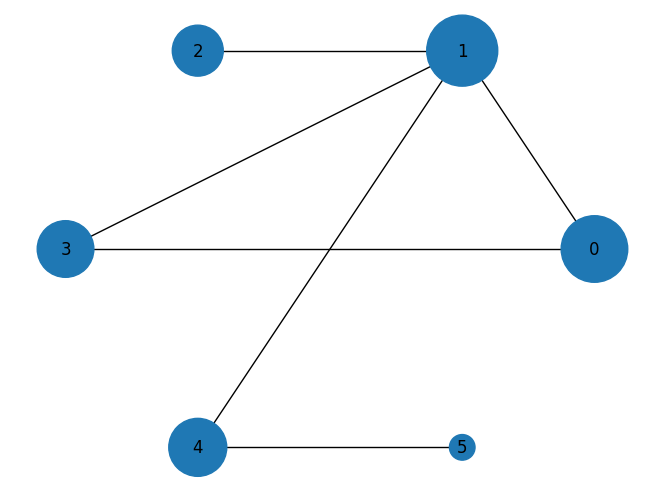

{0: 0.2301199694943095, 1: 0.2620605053119107, 2: 0.1342983620415058, 3: 0.16623889785910706, 4: 0.1733851400428506, 5: 0.033897125250316185}


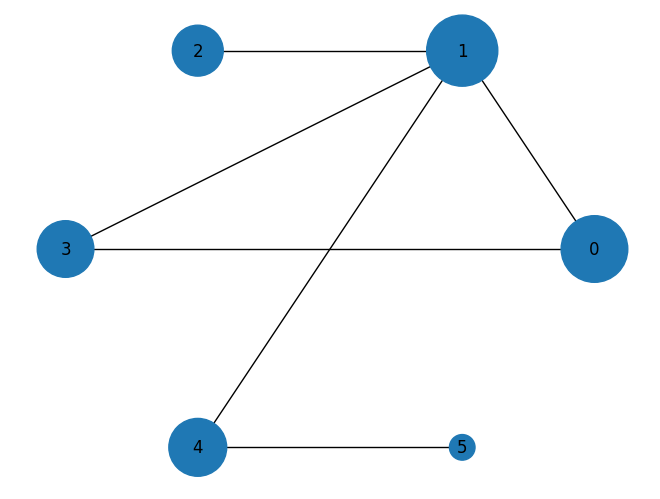

{0: 0.2300733040262365, 1: 0.2619642971339589, 2: 0.13440032470306906, 3: 0.1662913178107915, 4: 0.17341693278882406, 5: 0.03385382353711981}


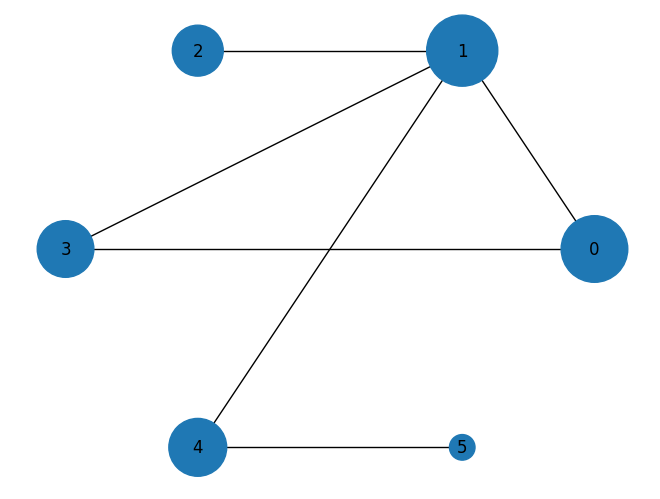

{0: 0.23010198535497053, 1: 0.26200794674858313, 2: 0.13438410117413283, 3: 0.16629006256774542, 4: 0.17335686779916543, 5: 0.03385903635540258}


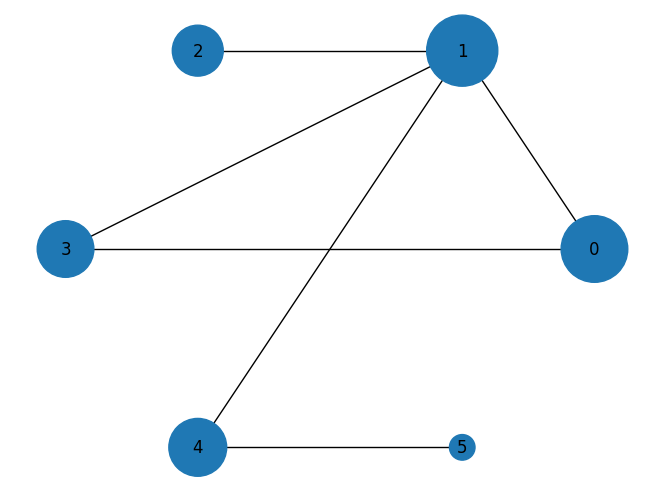

{0: 0.23009780466458132, 1: 0.26200072337880914, 2: 0.1343890485218977, 3: 0.16629196723612555, 4: 0.1733643932144921, 5: 0.03385606298409426}


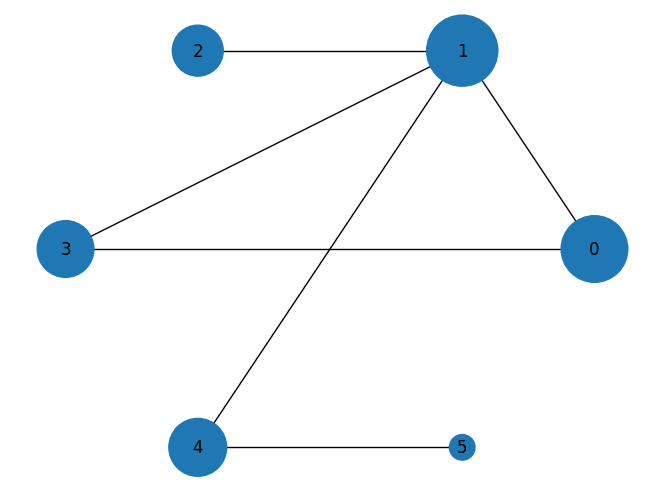

{0: 0.23009943292721716, 1: 0.26200317511117854, 2: 0.13438820637533327, 3: 0.1662919485592946, 4: 0.17336068794835233, 5: 0.033856549078624}


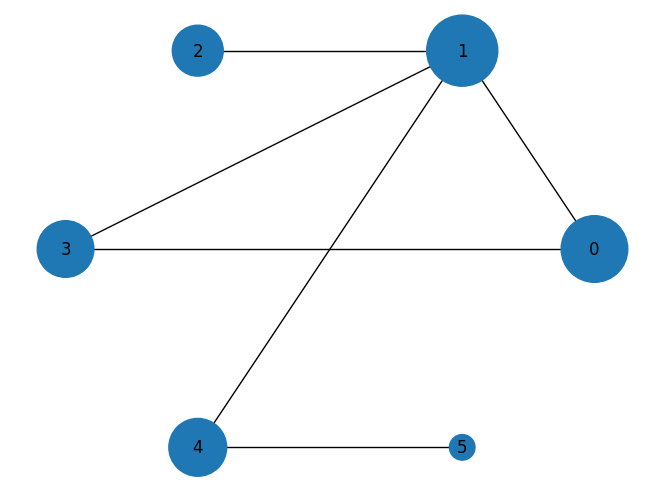

{0: 0.2300991584418688, 1: 0.2620027300392213, 2: 0.13438844364981098, 3: 0.1662920152471635, 4: 0.1733612807688859, 5: 0.03385637185304937}


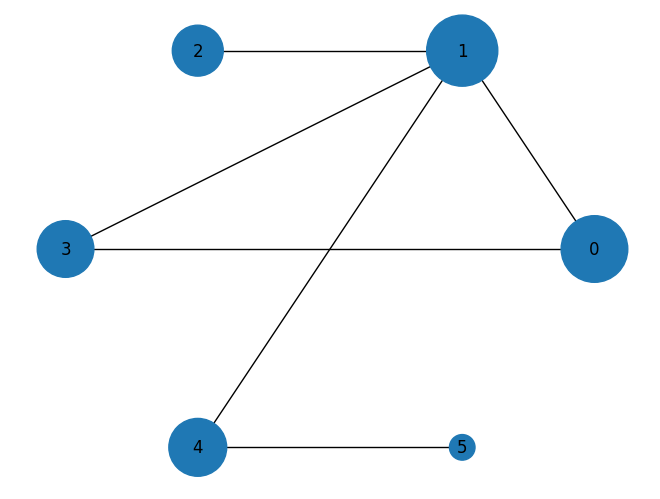

In [ ]:
for _ in range(10):
  r = GM.T @ r
  r = r/ r.sum()

  print({n:r_ for n,r_ in enumerate(r)})
  # plt.figure(figsize=(8,8))
  nx.draw_circular(graph, node_size=[r_*10000 for r_ in r], with_labels=True)
  plt.show()